In [16]:
import os
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, spectrogram, find_peaks, sosfiltfilt
from scipy.ndimage import gaussian_filter1d
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf


#### Testing JPM digital signal processing

In [3]:
# load FLAC file
input_flac_file = "ManualRockMovements-1/audio/Nicole_091823-000100.flac"
data, samplerate = sf.read(input_flac_file)

# if stereo (more than one channel), keep only one channel
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


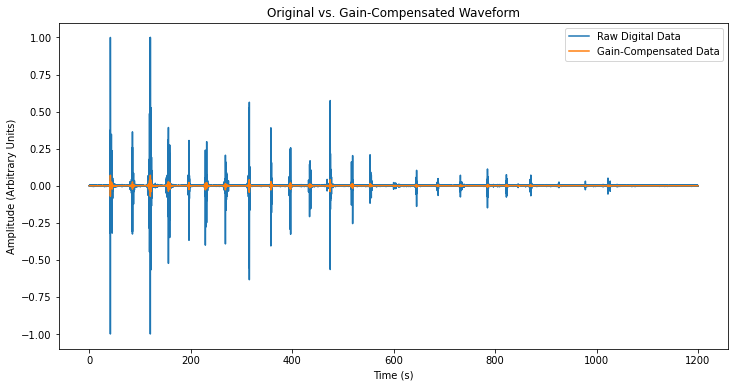

In [ ]:
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend()
plt.show()

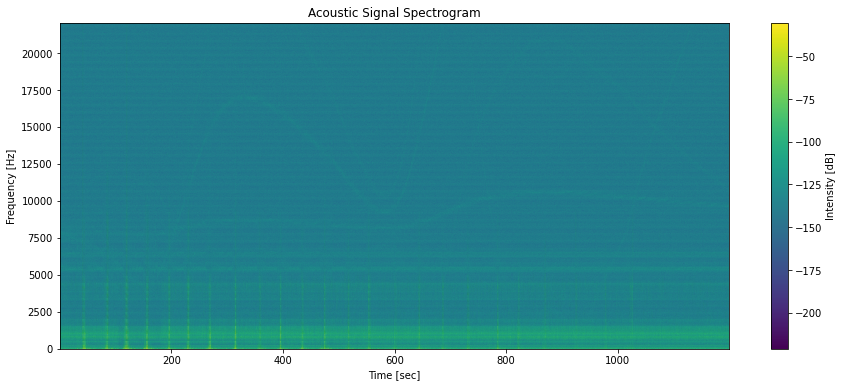

In [200]:
frequencies, times, Sxx = spectrogram(data, samplerate, nperseg=2048)
plt.figure(figsize=(15, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]') 
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Acoustic Signal Spectrogram')
plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
plt.show()

Determine range for visualization

In [19]:
# keep between 39 and 45 seconds of data for testing
data = data[samplerate*30:samplerate*60]

Sampling Rate: 44100 Hz
Original data shape: (1234800,)
Linear gain factor: 14.13


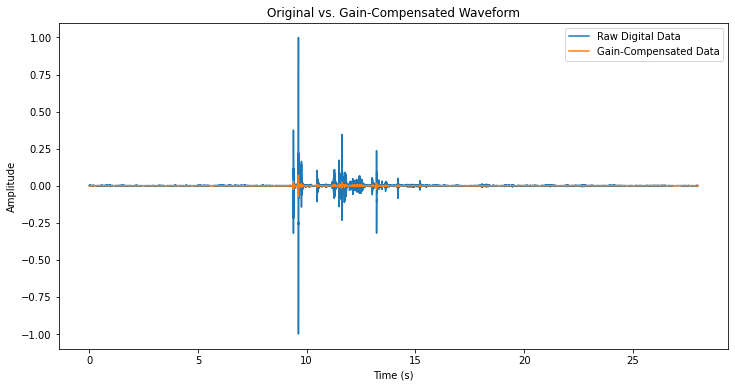

In [20]:
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend()
plt.show()

Spectrogram (for frequency high and low cut selection)

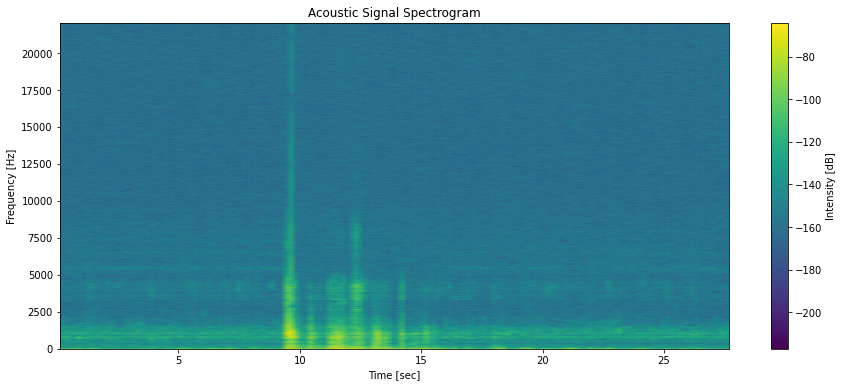

In [23]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=10000)
plt.figure(figsize=(15, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]') 
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Acoustic Signal Spectrogram')
plt.ylim([0, samplerate/2])  # limit y-axis to Nyquist frequency
plt.show()

Functions to select frequency band 

In [ ]:
def estimate_band_from_spectrogram(x, fs, t_window=None, nperseg=2048, noverlap=None, smooth_sigma=2, energy_frac=0.5, plot=True):
    """
    x: 1D audio signal
    fs: sampling rate (Hz)
    t_window: tuple (t0, t1) in seconds to average spectrogram over; if None uses entire signal
    nperseg: number of samples per segment - 2048 is common for audio (2**11, so FFT is efficient)
    energy_frac: fraction of peak energy to define band edges (0.5 ~ -3dB)
    returns: (low_cut, high_cut, f, Sxx_timeavg)
    """
    if noverlap is None:
        noverlap = nperseg // 2

    f, t, Sxx = spectrogram(x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
    # choose time window to average over
    if t_window is None:
        cols = np.arange(len(t))
    else:
        t0, t1 = t_window
        cols = np.where((t >= t0) & (t <= t1))[0]
        if cols.size == 0:
            cols = np.arange(len(t))

    # average spectral magnitude over chosen time columns
    spec_avg = Sxx[:, cols].mean(axis=1)
    spec_sm = gaussian_filter1d(spec_avg, smooth_sigma) # smooth to avoid tiny spikes

    # find main peak
    peak_idx = np.argmax(spec_sm)
    peak_val = spec_sm[peak_idx]
    thresh = peak_val * energy_frac # amplitude threshold for band edges

    # find indices above threshold and determine band edges
    above = np.where(spec_sm >= thresh)[0] # these are indices in f/spec_sm above the threshold
    low_idx = above[0] # lowest index above threshold
    high_idx = above[-1] # highest index above threshold
    low_cut = f[low_idx] # find the frequency at that index
    high_cut = f[high_idx] # find the frequency at that index

    # plot for verification
    if plot:
        plt.figure(figsize=(8,5))
        plt.plot(f, spec_sm, label="Smoothed avg spectrum")
        plt.axhline(thresh, color='gray', ls='--', label=f"Threshold ({energy_frac*100:.0f}% peak)")
        plt.axvline(f[peak_idx], color='red', ls=':', label=f"Peak = {f[peak_idx]:.1f} Hz")
        plt.axvline(low_cut, color='green', ls='--', label=f"Low cut = {low_cut:.1f} Hz")
        plt.axvline(high_cut, color='orange', ls='--', label=f"High cut = {high_cut:.1f} Hz")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.title("Averaged Spectrum with Band-pass Selection")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return low_cut, high_cut, f, spec_sm, t, Sxx

def design_and_apply_butter_bandpass(x, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if high >= 1.0:
        high = 0.9999
    if low <= 0.0:
        low = 1e-6
    sos = butter(order, [low, high], btype='band', output='sos')
    y = sosfiltfilt(sos, x)  # zero-phase to avoid phase distortion
    return y, sos

In [ ]:
# Example usage:
# x, fs = load_your_audio(...)  # e.g., librosa.load or scipy.io.wavfile.read
# choose time window around event (in seconds) - inspect your spectrogram to find t0,t1
# t_window = (1.5, 2.5)

# lowcut, highcut, f, spec_sm, t, Sxx = estimate_band_from_spectrogram(x, fs, t_window=t_window)
# print(f"Estimated band: {lowcut:.1f} Hz to {highcut:.1f} Hz")

# y, sos = design_and_apply_butter_bandpass(x, fs, lowcut, highcut, order=4)

# # Plot diagnostics
# fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=False)
# ax[0].plot(f, spec_sm / spec_sm.max())
# ax[0].axvline(lowcut, color='C1', linestyle='--', label='lowcut')
# ax[0].axvline(highcut, color='C2', linestyle='--', label='highcut')
# ax[0].set_xlabel('Frequency (Hz)')
# ax[0].set_ylabel('Normalized spectral magnitude')
# ax[0].legend()
#
# # spectrogram of filtered signal
# f2, t2, Sxx2 = spectrogram(y, fs=fs, nperseg=2048, noverlap=1024)
# im = ax[1].pcolormesh(t2, f2, 10*np.log10(Sxx2+1e-12), shading='auto')
# ax[1].set_ylim(0, fs/2)
# ax[1].set_ylabel('Frequency (Hz)')
# ax[1].set_xlabel('Time (s)')
# fig.colorbar(im, ax=ax[1], label='dB')
# plt.show()


### Band-Pass Filtering 

Getting rid of high frequency "backround noise" and ambient sounds

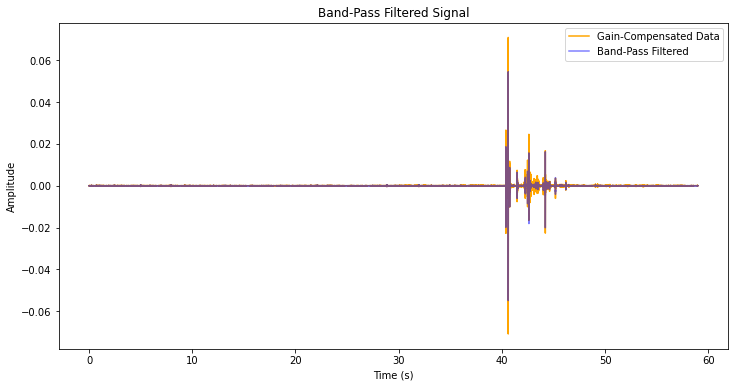

In [14]:
lowcut = 400  # low cutoff frequency in Hz
highcut = 1200 # high cutoff frequency in Hz
order = 4     # Filter order

# butterworth band-pass filter design (based off https://www.kaggle.com/code/sinamhd9/enjoy-clear-song-with-band-pass-filter)
nyquist = 0.5 * samplerate
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# Apply the filter forward and backward to prevent phase shift
filtered_data = filtfilt(b, a, calibrated_data)

# Visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Gain-Compensated Data", color='orange')
plt.plot(time, filtered_data, label="Band-Pass Filtered", color='blue', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend()
plt.show()

### Envelope Detection

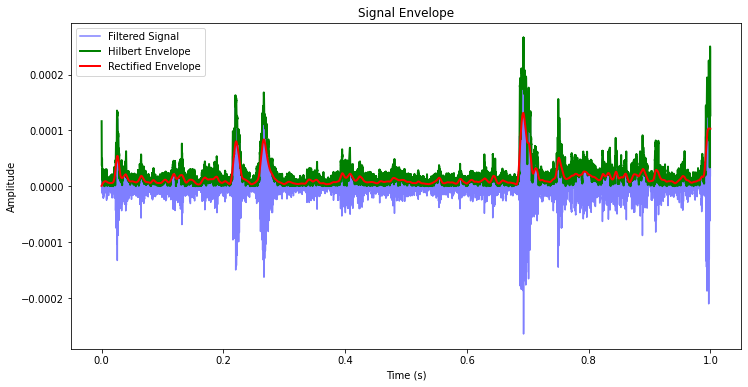

In [137]:
# using the hilbert transform 
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # very low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

# visualize the envelopes
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend()
plt.show()

### Pulse counting and Rectangular waveform

Detected 15 pulses.


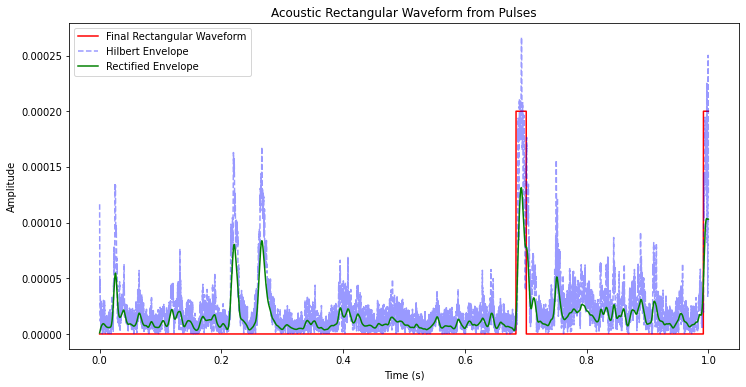

In [ ]:
from scipy.signal import find_peaks 

# Step 4: Pulse Counting
# The threshold should be calibrated based on background noise analysis.
peak_threshold = 0.0002
# The distance parameter is crucial for avoiding double counts on a single pulse.
# Calculate a sensible distance based on expected pulse duration (e.g., 5 ms).
min_pulse_duration = 0.0001 # seconds
min_distance_samples = int(min_pulse_duration * samplerate)

# Find peaks in the envelope
peaks, properties = find_peaks(envelope_hilbert, height=peak_threshold, distance=min_distance_samples)

print(f"Detected {len(peaks)} pulses.")

# Create the final rectangular waveform
pulse_width_samples = 500 # NOTE: pulse width should be defined based on the signal characteristic, need to change!! 
rectangular_waveform = np.zeros(len(filtered_data)) 
for peak_index in peaks:
    start_idx = max(0, peak_index - pulse_width_samples // 2)
    end_idx = min(len(filtered_data), peak_index + pulse_width_samples // 2)
    rectangular_waveform[start_idx:end_idx] = 0.0002

# Visualize the final rectangular waveform
plt.figure(figsize=(12, 6))
plt.plot(time, rectangular_waveform, 'r-', label="Final Rectangular Waveform")
plt.plot(time, envelope_hilbert, 'b--', alpha=0.4, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'g-', alpha=0.99, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Acoustic Rectangular Waveform from Pulses")
plt.legend()
plt.show() 


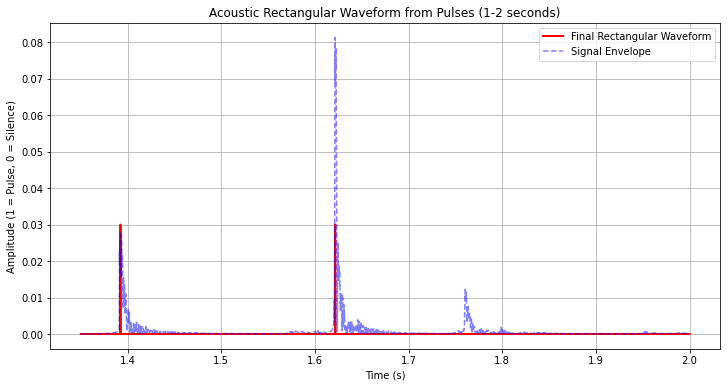

In [130]:
# Zoom in on 1-2 seconds
start_time = 1.35  # seconds
end_time = 2    # seconds
# Convert to integer indices
start_idx = int(start_time * samplerate)
end_idx = int(end_time * samplerate)
# Slice the data for the zoomed view
time_zoom = time[start_idx:end_idx]
rectangular_waveform_zoom = rectangular_waveform[start_idx:end_idx]
envelope_hilbert_zoom = envelope_hilbert[start_idx:end_idx]
# Visualize the zoomed rectangular waveform
plt.figure(figsize=(12, 6))
plt.plot(time_zoom, rectangular_waveform_zoom, 'r-', label="Final Rectangular Waveform", linewidth=2)
plt.plot(time_zoom, envelope_hilbert_zoom, 'b--', alpha=0.5, label='Signal Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (1 = Pulse, 0 = Silence)")
plt.title("Acoustic Rectangular Waveform from Pulses (1-2 seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Testing Manual Particle Movement Experiment Calibration


## MRM 1 - Japanese Pipe Micriphone

C:\Users\nicol\AppData\Local\Temp\ipykernel_5324\56214427.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


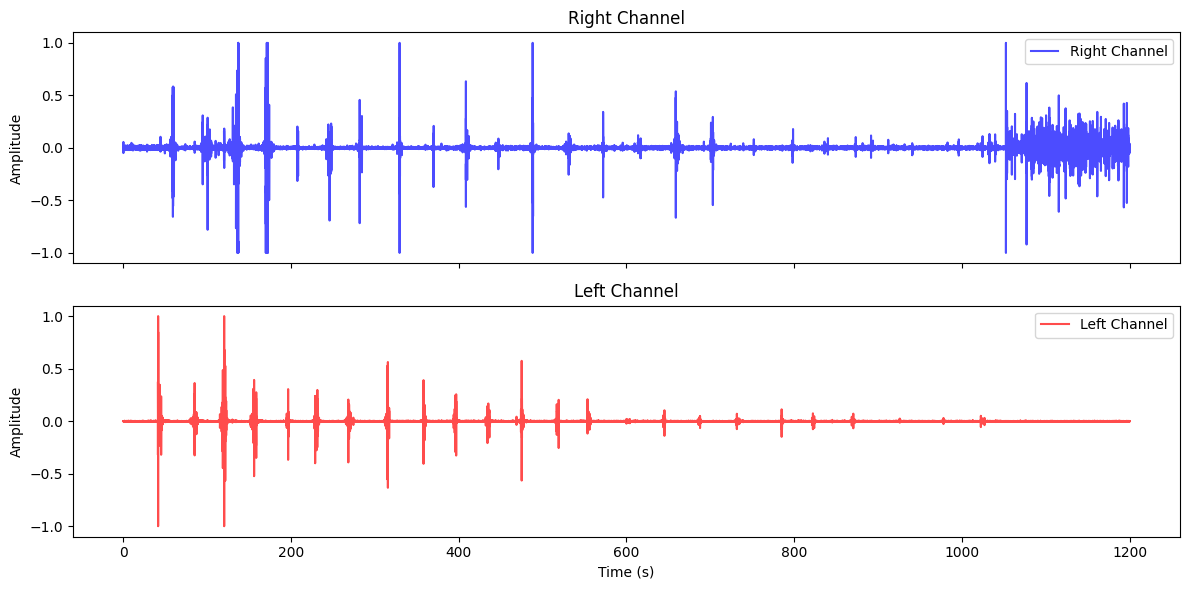

In [2]:
filepath = 'ManualRockMovements-1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The left channel is the impact pipe. This is true for all calibration recordings for H1 in 2023

#### Compute and plotting envelope

In [63]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_5324\3310124320.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


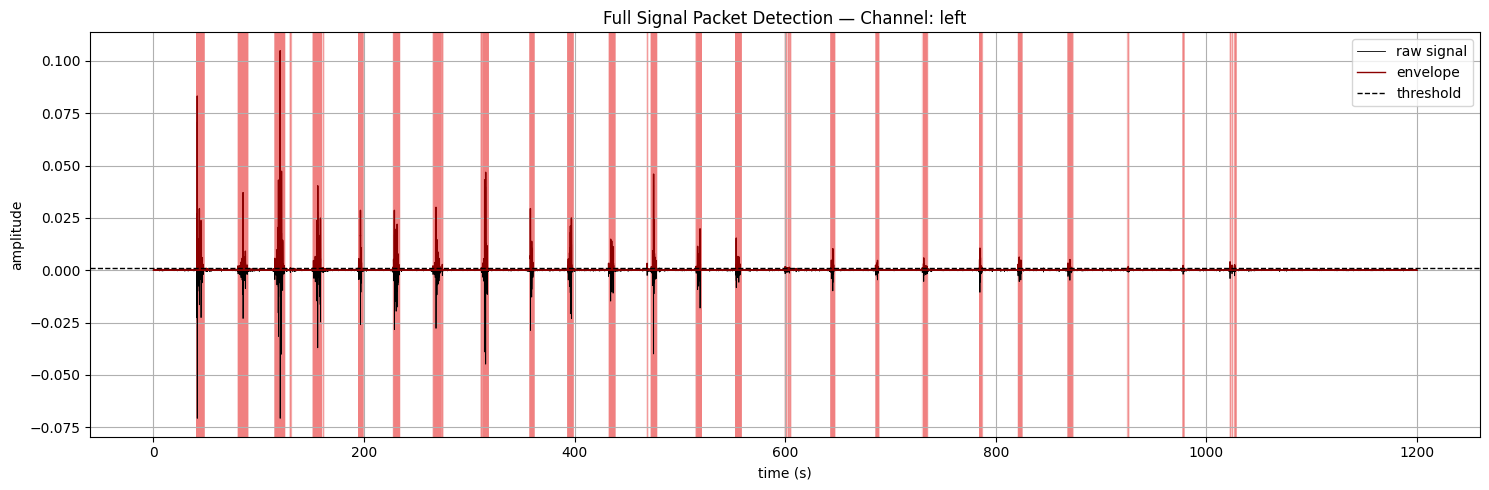

In [64]:
time = np.arange(len(y)) / sr

# plot
plt.figure(figsize=(15, 5))
plt.plot(time, y, color='black', linewidth=0.6, label="raw signal")
plt.plot(time, envelope, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# shade packet zones
for s, e in zip(packet_starts, packet_ends):
    plt.axvspan(time[s], time[e], color='lightcoral', alpha=0.4)

# De-duplicate Δtₚ label in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]  # safety check
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Full Signal Packet Detection — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\nicol\AppData\Local\Temp\ipykernel_5324\3768854100.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max amplitude in the zoomed-in window: 0.10


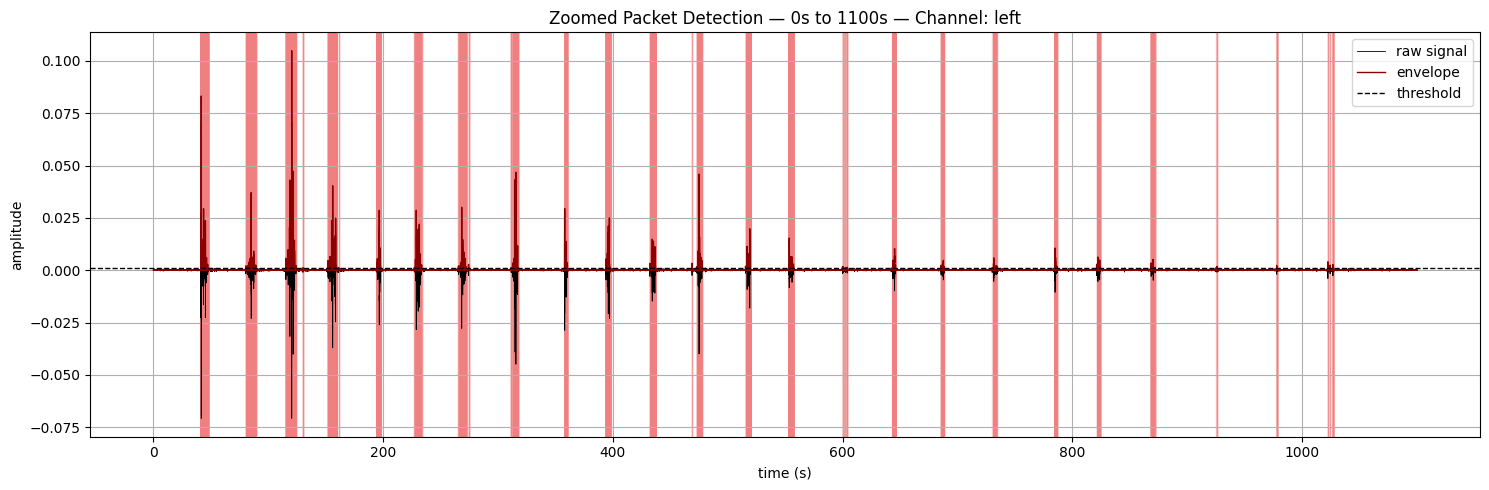

In [65]:
start_time = 0  # in seconds
end_time = 1100  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()


In [66]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Detected 5354 packets in 1200.00 seconds of audio.


Plotting and Saving Rock Movement Calibrations

In [7]:
# import csv
csv_path = 'ManualRockMovements-1/mov1_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-1/plots', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Particle ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-1/plots/pipe_signal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

    print(f"Saved plot for group {id_num} to {plot_filename}")

Saved plot for group 167 to ManualRockMovements-1/plots/pipe_signal_167.png
Saved plot for group 6 to ManualRockMovements-1/plots/pipe_signal_6.png
Saved plot for group 8 to ManualRockMovements-1/plots/pipe_signal_8.png
Saved plot for group 168 to ManualRockMovements-1/plots/pipe_signal_168.png
Saved plot for group 150 to ManualRockMovements-1/plots/pipe_signal_150.png
Saved plot for group 11 to ManualRockMovements-1/plots/pipe_signal_11.png
Saved plot for group 22 to ManualRockMovements-1/plots/pipe_signal_22.png
Saved plot for group 152 to ManualRockMovements-1/plots/pipe_signal_152.png
Saved plot for group 12 to ManualRockMovements-1/plots/pipe_signal_12.png
Saved plot for group 96 to ManualRockMovements-1/plots/pipe_signal_96.png
Saved plot for group 101 to ManualRockMovements-1/plots/pipe_signal_101.png
Saved plot for group 24 to ManualRockMovements-1/plots/pipe_signal_24.png
Saved plot for group 107 to ManualRockMovements-1/plots/pipe_signal_107.png
Saved plot for group 162 to Ma

Displaying the max amplitude for each particle ID

In [69]:
# import csv
csv_path = 'ManualRockMovements-1/mov1_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Particle ID {id_num}: Max Raw amplitude = {max_amp:.4f}")


Particle ID 167: Max Raw amplitude = 0.0708
Particle ID 6: Max Raw amplitude = 0.0257
Particle ID 8: Max Raw amplitude = 0.0708
Particle ID 168: Max Raw amplitude = 0.0371
Particle ID 150: Max Raw amplitude = 0.0261
Particle ID 11: Max Raw amplitude = 0.0284
Particle ID 22: Max Raw amplitude = 0.0278
Particle ID 152: Max Raw amplitude = 0.0449
Particle ID 12: Max Raw amplitude = 0.0288
Particle ID 96: Max Raw amplitude = 0.0232
Particle ID 101: Max Raw amplitude = 0.0148
Particle ID 24: Max Raw amplitude = 0.0407
Particle ID 107: Max Raw amplitude = 0.0181
Particle ID 162: Max Raw amplitude = 0.0148
Particle ID 159: Max Raw amplitude = 0.0017
Particle ID 35: Max Raw amplitude = 0.0099
Particle ID 69: Max Raw amplitude = 0.0046
Particle ID 85: Max Raw amplitude = 0.0054
Particle ID 61: Max Raw amplitude = 0.0106
Particle ID 52: Max Raw amplitude = 0.0054
Particle ID 165: Max Raw amplitude = 0.0051
Particle ID 166: Max Raw amplitude = 0.0018
Particle ID 53: Max Raw amplitude = 0.0022
Par

In [70]:
# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Particle ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")

Particle ID 167: Max Envelope amplitude = 0.0832
Particle ID 6: Max Envelope amplitude = 0.0371
Particle ID 8: Max Envelope amplitude = 0.1049
Particle ID 168: Max Envelope amplitude = 0.0403
Particle ID 150: Max Envelope amplitude = 0.0286
Particle ID 11: Max Envelope amplitude = 0.0286
Particle ID 22: Max Envelope amplitude = 0.0301
Particle ID 152: Max Envelope amplitude = 0.0468
Particle ID 12: Max Envelope amplitude = 0.0295
Particle ID 96: Max Envelope amplitude = 0.0250
Particle ID 101: Max Envelope amplitude = 0.0148
Particle ID 24: Max Envelope amplitude = 0.0459
Particle ID 107: Max Envelope amplitude = 0.0198
Particle ID 162: Max Envelope amplitude = 0.0154
Particle ID 159: Max Envelope amplitude = 0.0017
Particle ID 35: Max Envelope amplitude = 0.0103
Particle ID 69: Max Envelope amplitude = 0.0047
Particle ID 85: Max Envelope amplitude = 0.0059
Particle ID 61: Max Envelope amplitude = 0.0106
Particle ID 52: Max Envelope amplitude = 0.0063
Particle ID 165: Max Envelope ampl

## MRM 1 - Hydrophone

In [9]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the hydrophone

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_5324\3310124320.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


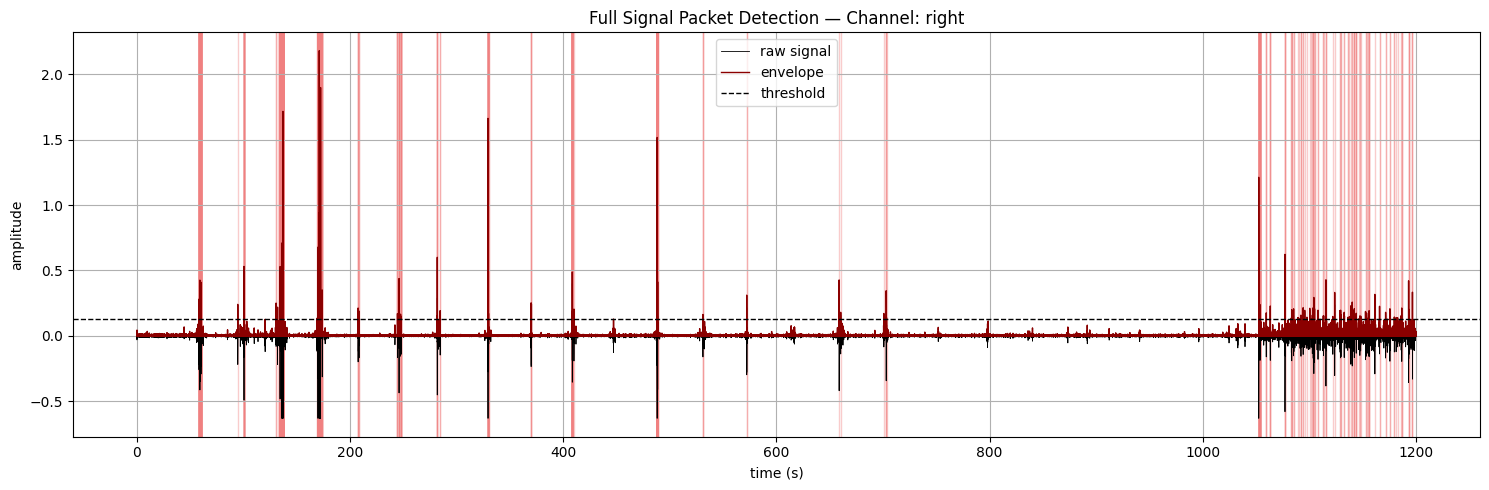

In [10]:
time = np.arange(len(y)) / sr

# plot
plt.figure(figsize=(15, 5))
plt.plot(time, y, color='black', linewidth=0.6, label="raw signal")
plt.plot(time, envelope, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# shade packet zones
for s, e in zip(packet_starts, packet_ends):
    plt.axvspan(time[s], time[e], color='lightcoral', alpha=0.4)

# De-duplicate Δtₚ label in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]  # safety check
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Full Signal Packet Detection — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

Plotting and Saving Rock Movement Calibrations

In [59]:
# import csv
csv_path = 'ManualRockMovements-1/mov1_mic_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-1/plots/hydrophones', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Particle ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-1/plots/hydrophones/mic_signal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

Displaying the max amplitude for each particle ID 

In [62]:
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Particle ID {id_num}: Max Raw amplitude = {max_amp:.4f}")  

Particle ID 167: Max Raw amplitude = 0.4140
Particle ID 6: Max Raw amplitude = 0.4920
Particle ID 8: Max Raw amplitude = 0.6310
Particle ID 168: Max Raw amplitude = 0.6310
Particle ID 150: Max Raw amplitude = 0.1989
Particle ID 11: Max Raw amplitude = 0.4366
Particle ID 22: Max Raw amplitude = 0.4523
Particle ID 152: Max Raw amplitude = 0.6310
Particle ID 12: Max Raw amplitude = 0.2351
Particle ID 96: Max Raw amplitude = 0.3999
Particle ID 101: Max Raw amplitude = 0.1285
Particle ID 24: Max Raw amplitude = 0.6310
Particle ID 107: Max Raw amplitude = 0.1611
Particle ID 162: Max Raw amplitude = 0.2978
Particle ID 159: Max Raw amplitude = 0.0761
Particle ID 35: Max Raw amplitude = 0.4197
Particle ID 69: Max Raw amplitude = 0.3436
Particle ID 85: Max Raw amplitude = 0.0519
Particle ID 61: Max Raw amplitude = 0.1132
Particle ID 52: Max Raw amplitude = 0.0585
Particle ID 165: Max Raw amplitude = 0.0745
Particle ID 166: Max Raw amplitude = 0.0443
Particle ID 53: Max Raw amplitude = 0.0510
Par

In [61]:
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope signal
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude from the envelope
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Particle ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")


Particle ID 167: Max Envelope amplitude = 0.4262
Particle ID 6: Max Envelope amplitude = 0.5310
Particle ID 8: Max Envelope amplitude = 1.7166
Particle ID 168: Max Envelope amplitude = 2.1810
Particle ID 150: Max Envelope amplitude = 0.2129
Particle ID 11: Max Envelope amplitude = 0.4382
Particle ID 22: Max Envelope amplitude = 0.6008
Particle ID 152: Max Envelope amplitude = 1.6635
Particle ID 12: Max Envelope amplitude = 0.2524
Particle ID 96: Max Envelope amplitude = 0.4876
Particle ID 101: Max Envelope amplitude = 0.1286
Particle ID 24: Max Envelope amplitude = 1.5174
Particle ID 107: Max Envelope amplitude = 0.1636
Particle ID 162: Max Envelope amplitude = 0.3113
Particle ID 159: Max Envelope amplitude = 0.0769
Particle ID 35: Max Envelope amplitude = 0.4275
Particle ID 69: Max Envelope amplitude = 0.3450
Particle ID 85: Max Envelope amplitude = 0.0649
Particle ID 61: Max Envelope amplitude = 0.1132
Particle ID 52: Max Envelope amplitude = 0.0604
Particle ID 165: Max Envelope ampl

## MRM 2 - Impact Pipe

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\2022536935.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


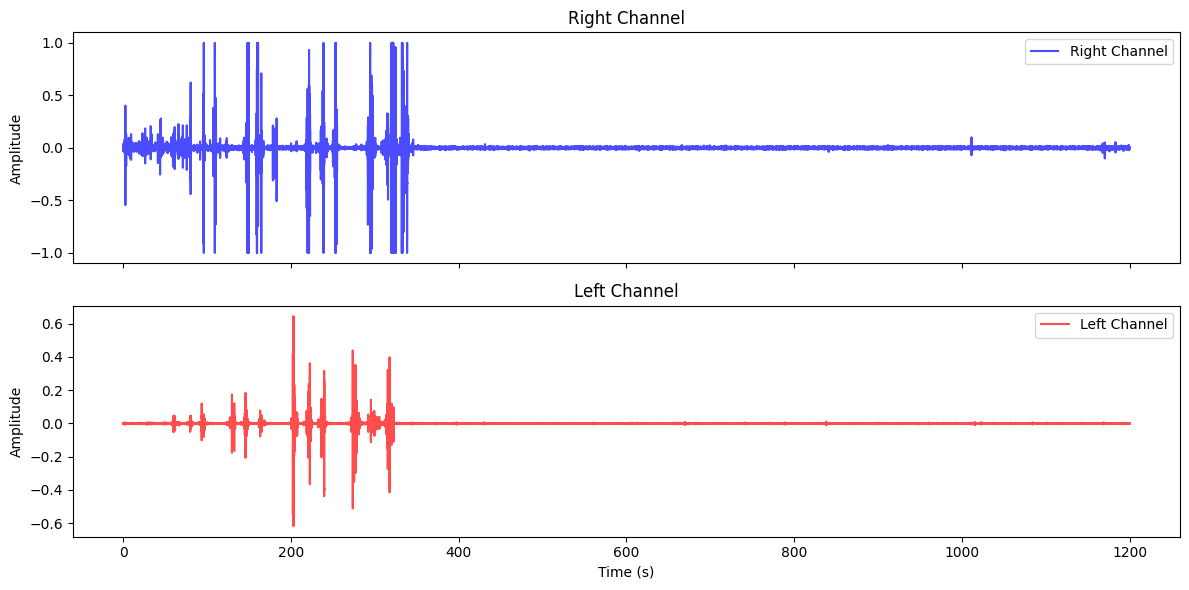

In [3]:
filepath = 'ManualRockMovements-2/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Left channel is impact pipe also, since these experiments were on the same day MRM1

#### Compute and plotting envelope

In [4]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\2789492015.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max amplitude in the zoomed-in window: 0.05


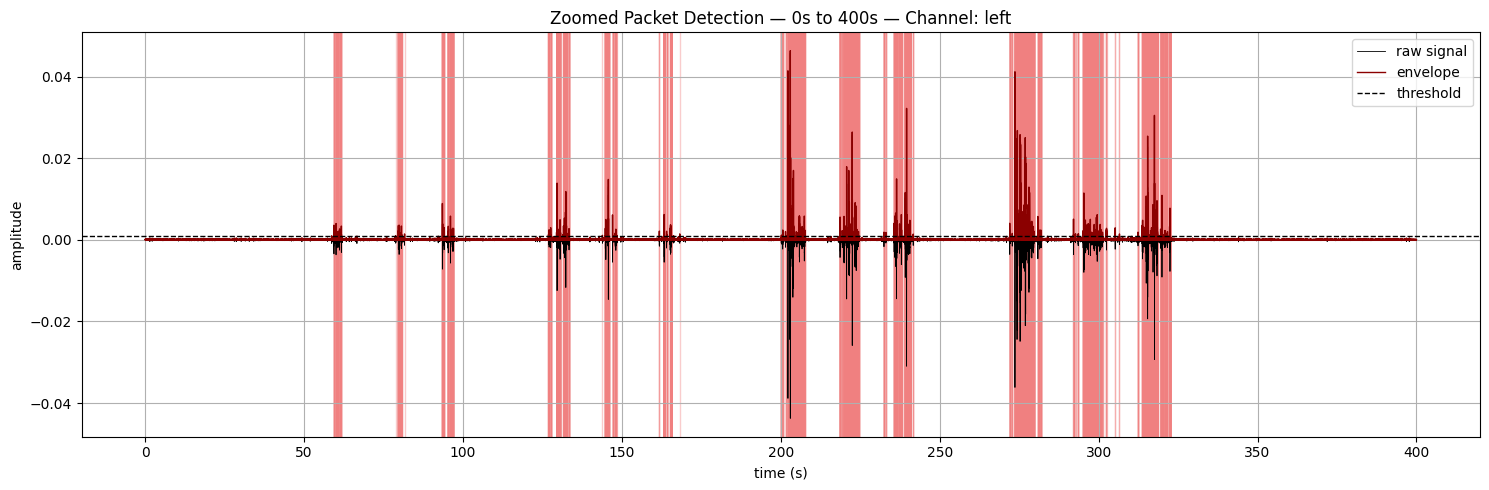

In [5]:
start_time = 0  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()


In [6]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Detected 4089 packets in 1200.00 seconds of audio.


Plotting and saving group impacts

In [11]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-2/plots', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Group ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-2/plots/pipe_groupsignal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

    print(f"Saved plot for group {id_num} to {plot_filename}")

Saved plot for group 1.1 to ManualRockMovements-2/plots/pipe_groupsignal_1.1.png
Saved plot for group 1.2 to ManualRockMovements-2/plots/pipe_groupsignal_1.2.png
Saved plot for group 1.3 to ManualRockMovements-2/plots/pipe_groupsignal_1.3.png
Saved plot for group 2.1 to ManualRockMovements-2/plots/pipe_groupsignal_2.1.png
Saved plot for group 2.2 to ManualRockMovements-2/plots/pipe_groupsignal_2.2.png
Saved plot for group 2.3 to ManualRockMovements-2/plots/pipe_groupsignal_2.3.png
Saved plot for group 3.1 to ManualRockMovements-2/plots/pipe_groupsignal_3.1.png
Saved plot for group 3.2 to ManualRockMovements-2/plots/pipe_groupsignal_3.2.png
Saved plot for group 3.3 to ManualRockMovements-2/plots/pipe_groupsignal_3.3.png
Saved plot for group 4.1 to ManualRockMovements-2/plots/pipe_groupsignal_4.1.png
Saved plot for group 4.2 to ManualRockMovements-2/plots/pipe_groupsignal_4.2.png
Saved plot for group 4.3 to ManualRockMovements-2/plots/pipe_groupsignal_4.3.png


Displaying the max amplitude for each particle ID

In [9]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_pipe_particles.csv'
times_df = pd.read_csv(csv_path)

# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Group ID {id_num}: Max Raw amplitude = {max_amp:.4f}")


Group ID 1.1: Max Raw amplitude = 0.0037
Group ID 1.2: Max Raw amplitude = 0.0036
Group ID 1.3: Max Raw amplitude = 0.0085
Group ID 2.1: Max Raw amplitude = 0.0125
Group ID 2.2: Max Raw amplitude = 0.0146
Group ID 2.3: Max Raw amplitude = 0.0055
Group ID 3.1: Max Raw amplitude = 0.0457
Group ID 3.2: Max Raw amplitude = 0.0259
Group ID 3.3: Max Raw amplitude = 0.0310
Group ID 4.1: Max Raw amplitude = 0.0362
Group ID 4.2: Max Raw amplitude = 0.0101
Group ID 4.3: Max Raw amplitude = 0.0293


In [10]:
# loop through each row of the DataFrame
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Group ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")

Group ID 1.1: Max Envelope amplitude = 0.0040
Group ID 1.2: Max Envelope amplitude = 0.0036
Group ID 1.3: Max Envelope amplitude = 0.0089
Group ID 2.1: Max Envelope amplitude = 0.0139
Group ID 2.2: Max Envelope amplitude = 0.0148
Group ID 2.3: Max Envelope amplitude = 0.0062
Group ID 3.1: Max Envelope amplitude = 0.0463
Group ID 3.2: Max Envelope amplitude = 0.0264
Group ID 3.3: Max Envelope amplitude = 0.0322
Group ID 4.1: Max Envelope amplitude = 0.0412
Group ID 4.2: Max Envelope amplitude = 0.0115
Group ID 4.3: Max Envelope amplitude = 0.0305


## MRM 2 - Hydrophone

In [12]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the hydrophone

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\2703734550.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max amplitude in the zoomed-in window: 2.84


c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


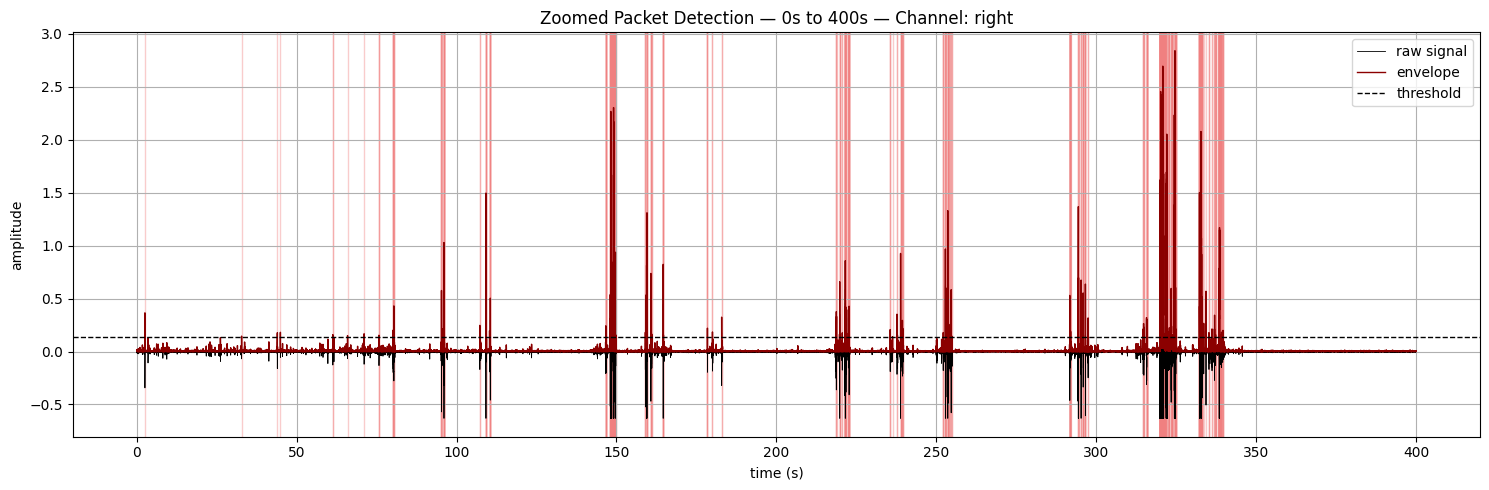

In [13]:
start_time = 0  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()

Plotting and saving groups

In [30]:
# import csv
csv_path = 'ManualRockMovements-2/mov2_mic_particles.csv'
times_df = pd.read_csv(csv_path)

# Make sure "plots" folder exists
os.makedirs('ManualRockMovements-2/plots/hydrophones', exist_ok=True)

# Iterate through each row of the dataframe
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Convert times to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # Slice the arrays
    y_zoom = y[start_idx:end_idx]
    envelope_zoom = envelope[start_idx:end_idx]
    time_zoom = np.arange(start_idx, end_idx) / sr

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
    plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
    plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

    # Shade packets only if within the zoomed window
    for start, end in zip(packet_starts, packet_ends):
        if start >= start_idx and end <= end_idx:
            plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

    # Clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.title(f"Zoomed Packet Detection — Group ID: {id_num} — {start_time}s to {end_time}s — Channel: {use_channel}")
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"ManualRockMovements-2/plots/hydrophones/mic_groupsignal_{id_num}.png"
    plt.savefig(plot_filename, dpi=300)
    plt.close()

Displaying the max amplitude for each particle ID

In [33]:
csv_path = 'ManualRockMovements-2/mov2_mic_particles.csv'
times_df = pd.read_csv(csv_path)

for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the raw signal
    y_zoom = y[start_idx:end_idx]

    # get max amplitude
    max_amp = np.max(np.abs(y_zoom))

    print(f"Group ID {id_num}: Max Raw amplitude = {max_amp:.4f}")  

Group ID 1.1: Max Raw amplitude = 0.3924
Group ID 1.2: Max Raw amplitude = 0.6310
Group ID 1.3: Max Raw amplitude = 0.6310
Group ID 2.1: Max Raw amplitude = 0.6310
Group ID 2.2: Max Raw amplitude = 0.6310
Group ID 2.3: Max Raw amplitude = 0.3205
Group ID 3.1: Max Raw amplitude = 0.6310
Group ID 3.2: Max Raw amplitude = 0.6310
Group ID 3.3: Max Raw amplitude = 0.6310
Group ID 4.1: Max Raw amplitude = 0.6310
Group ID 4.2: Max Raw amplitude = 0.6310
Group ID 4.3: Max Raw amplitude = 0.6310


In [34]:
for idx, row in times_df.iterrows():
    id_num = row['id']
    start_time = row['start_time']
    end_time = row['end_time']

    # convert to sample indices
    start_idx = int(start_time * sr)
    end_idx = int(end_time * sr)

    # slice the envelope signal
    envelope_zoom = envelope[start_idx:end_idx]

    # get max amplitude from the envelope
    max_amp = np.max(np.abs(envelope_zoom))

    print(f"Particle ID {id_num}: Max Envelope amplitude = {max_amp:.4f}")


Particle ID 1.1: Max Envelope amplitude = 0.4311
Particle ID 1.2: Max Envelope amplitude = 1.0295
Particle ID 1.3: Max Envelope amplitude = 1.4968
Particle ID 2.1: Max Envelope amplitude = 2.3044
Particle ID 2.2: Max Envelope amplitude = 1.3107
Particle ID 2.3: Max Envelope amplitude = 0.3248
Particle ID 3.1: Max Envelope amplitude = 0.8576
Particle ID 3.2: Max Envelope amplitude = 0.9267
Particle ID 3.3: Max Envelope amplitude = 1.3308
Particle ID 4.1: Max Envelope amplitude = 1.3686
Particle ID 4.2: Max Envelope amplitude = 2.8416
Particle ID 4.3: Max Envelope amplitude = 2.0784


# Flood Experiments

### Flood 1

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\626725145.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


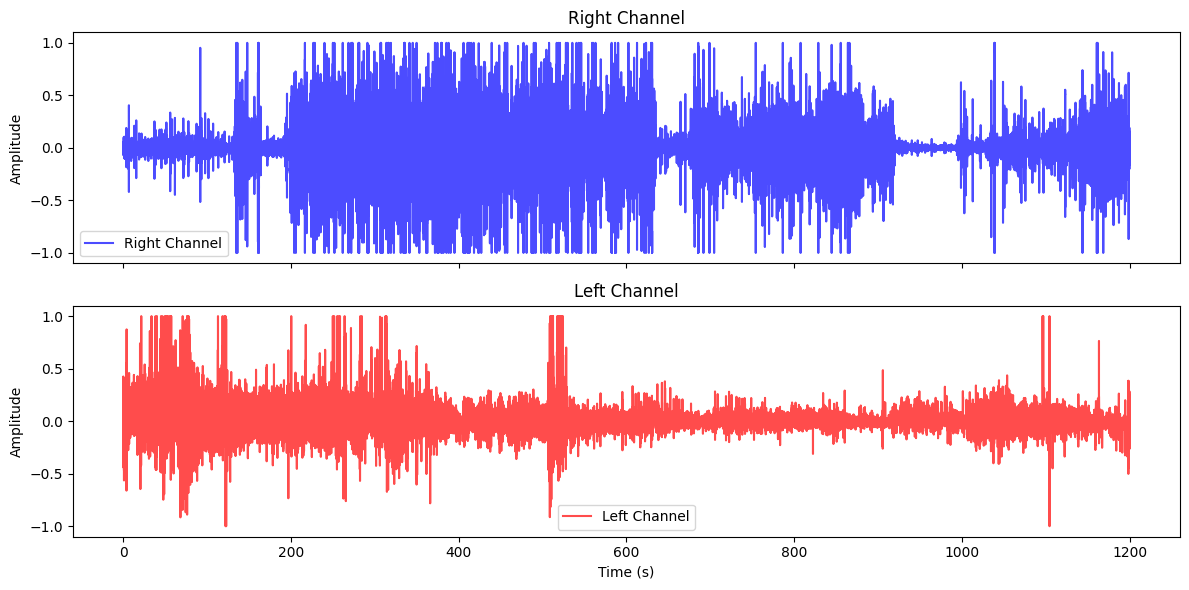

In [59]:
filepath = 'EXP-09-20-23-FLOW1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe recording: unusable
- For some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
- Still gonna try to see if it gives me anything

In [60]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\4048399169.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.1788
Max raw signal amplitude in the zoomed-in window: 0.0708


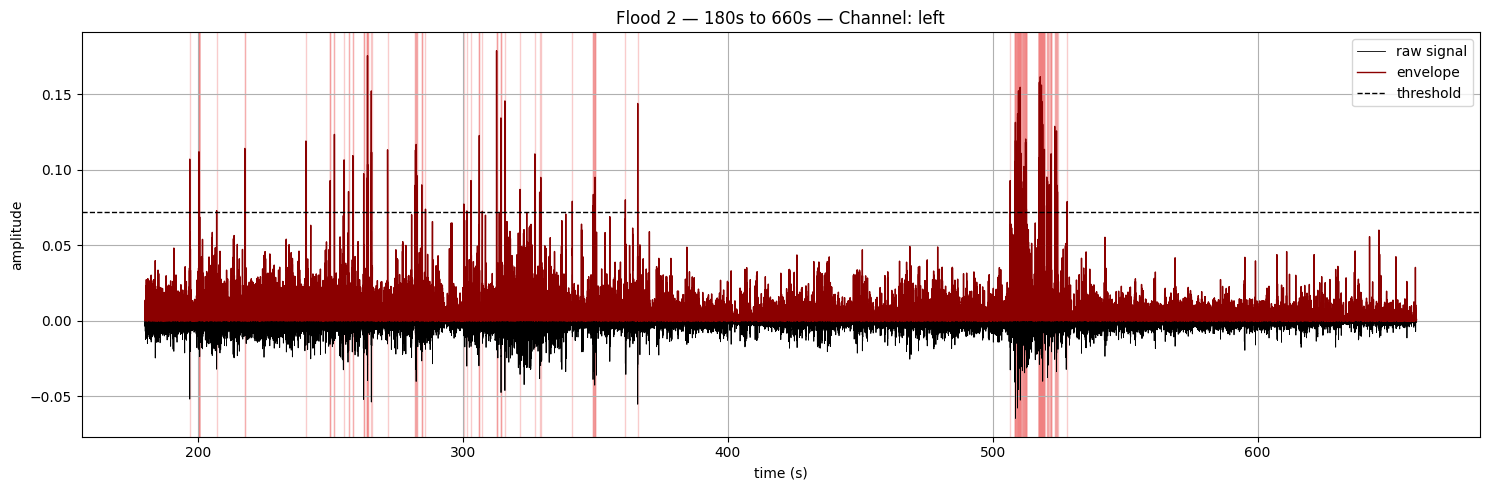

In [61]:
start_time = 180  # in seconds
end_time = 660  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()  

microphone

In [36]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\2027646839.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 1.6488
Max signal amplitude in the zoomed-in window: 0.6310


c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


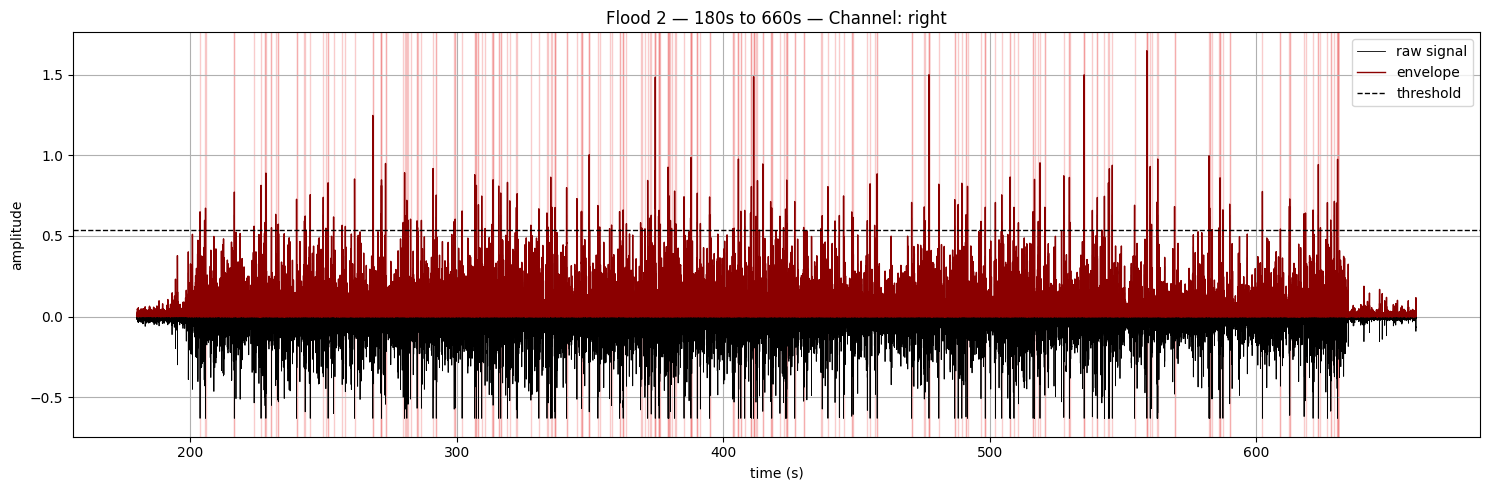

In [ ]:
start_time = 180  # in seconds
end_time = 660  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()  

### Flood 2

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3555298314.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


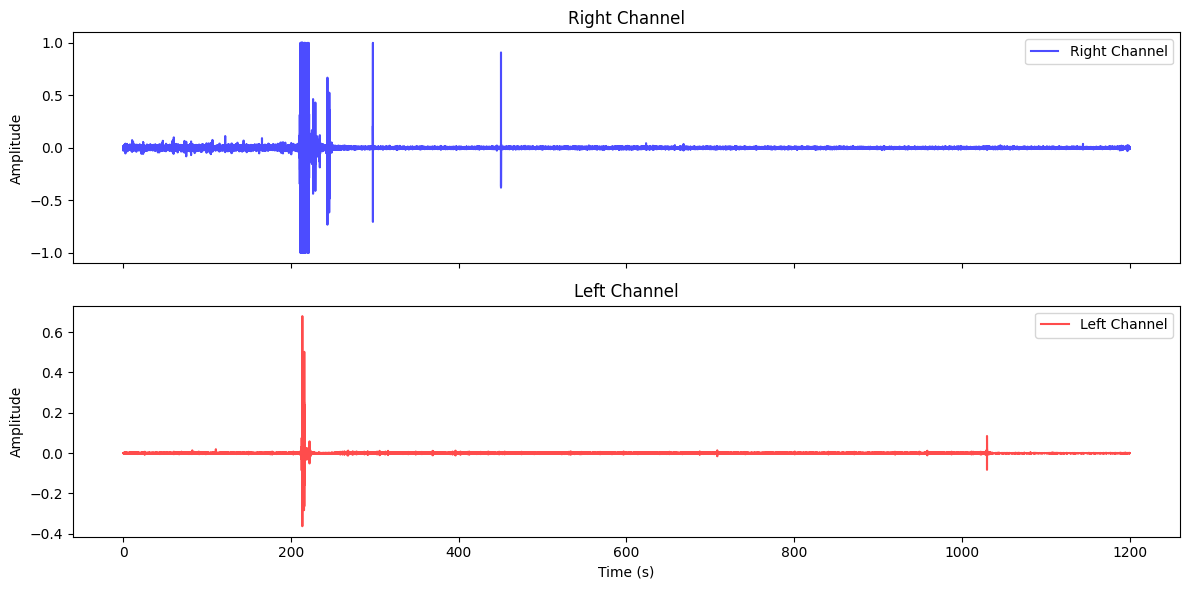

In [40]:
filepath = 'EXP-09-20-23-FLOW2/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [41]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 0.0487
Max raw signal amplitude in the zoomed-in window: 0.0481


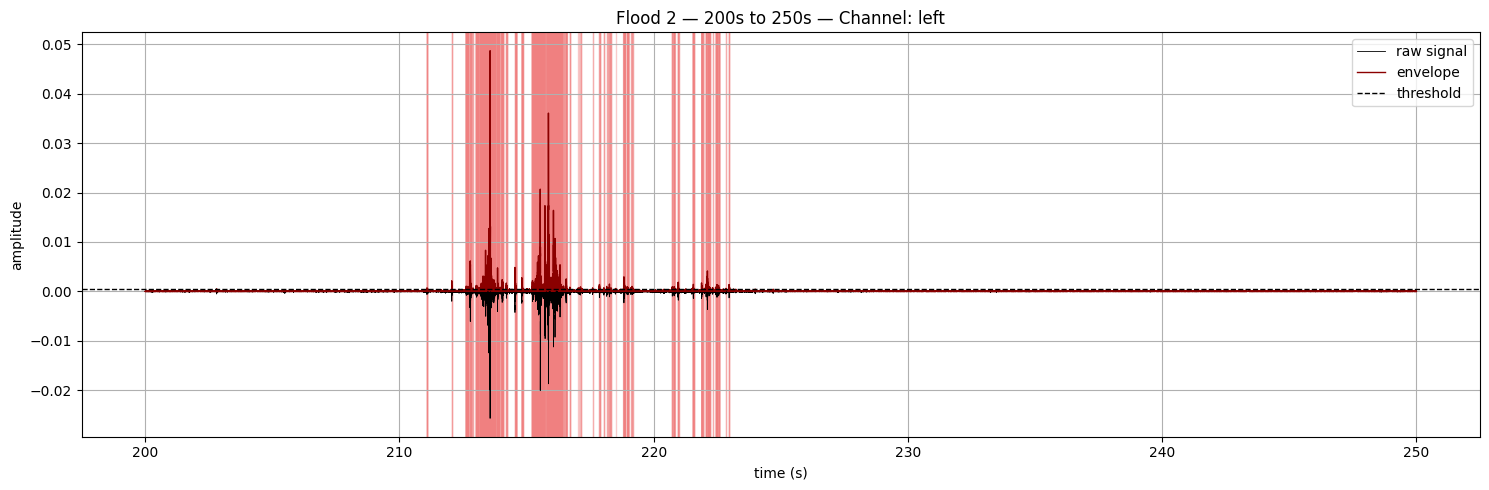

In [42]:
start_time = 200  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()


microphone

In [43]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 2.6674
Max raw signal amplitude in the zoomed-in window: 0.6310


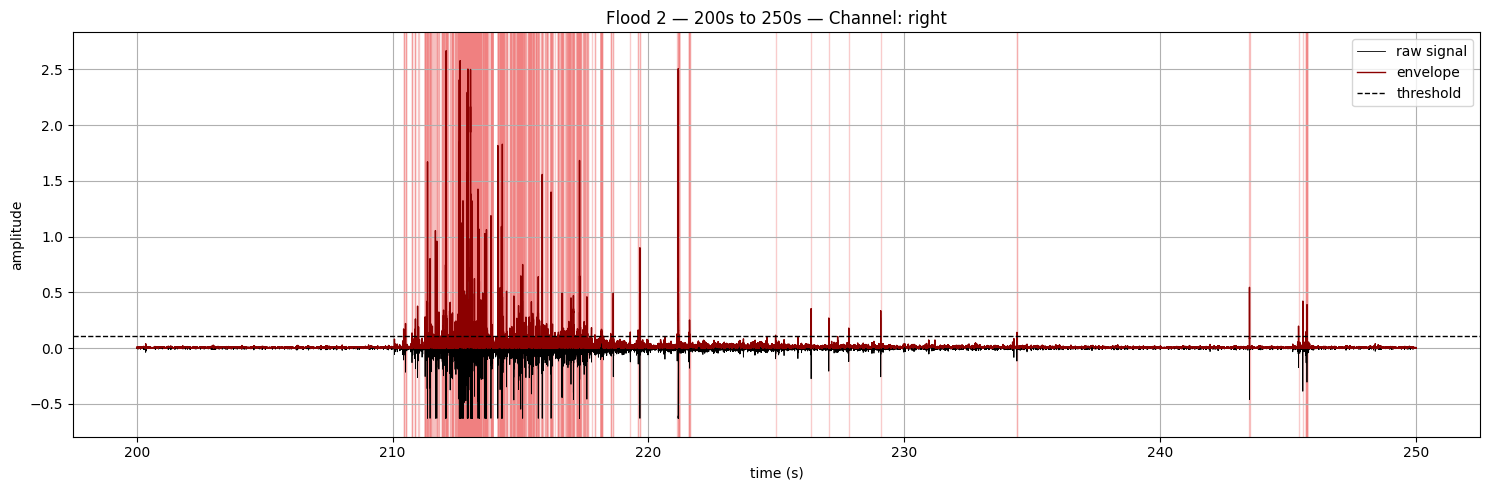

In [44]:
start_time = 200  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 2 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()


### Flood 3

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\539970300.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


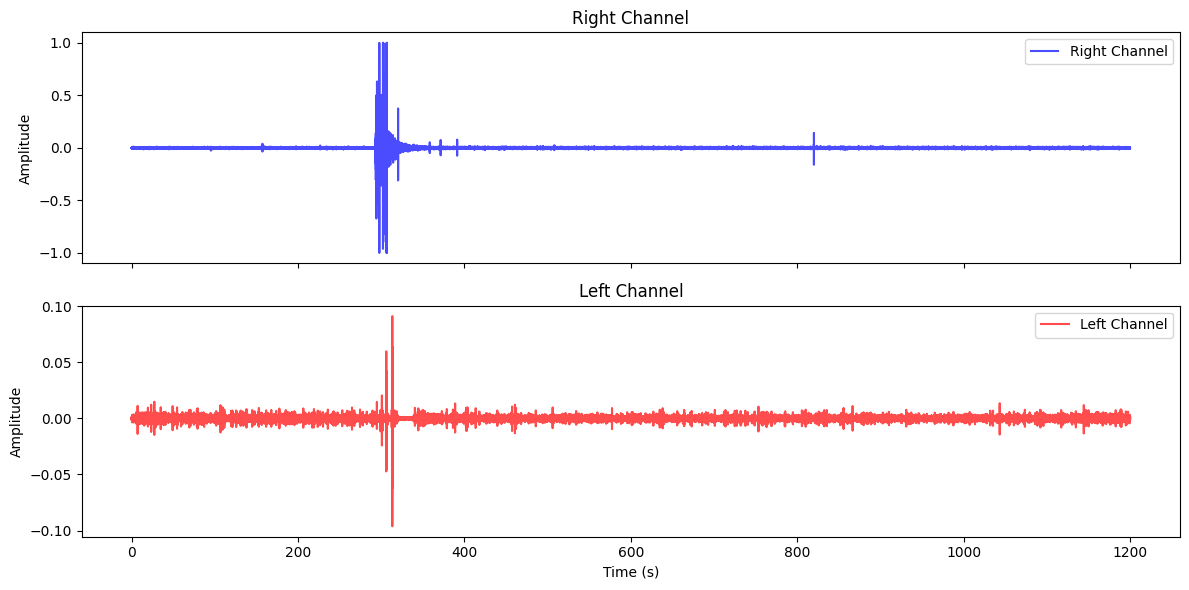

In [45]:
filepath = 'EXP-09-20-23-FLOW3/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [46]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 0.0076
Max raw signal amplitude in the zoomed-in window: 0.0068


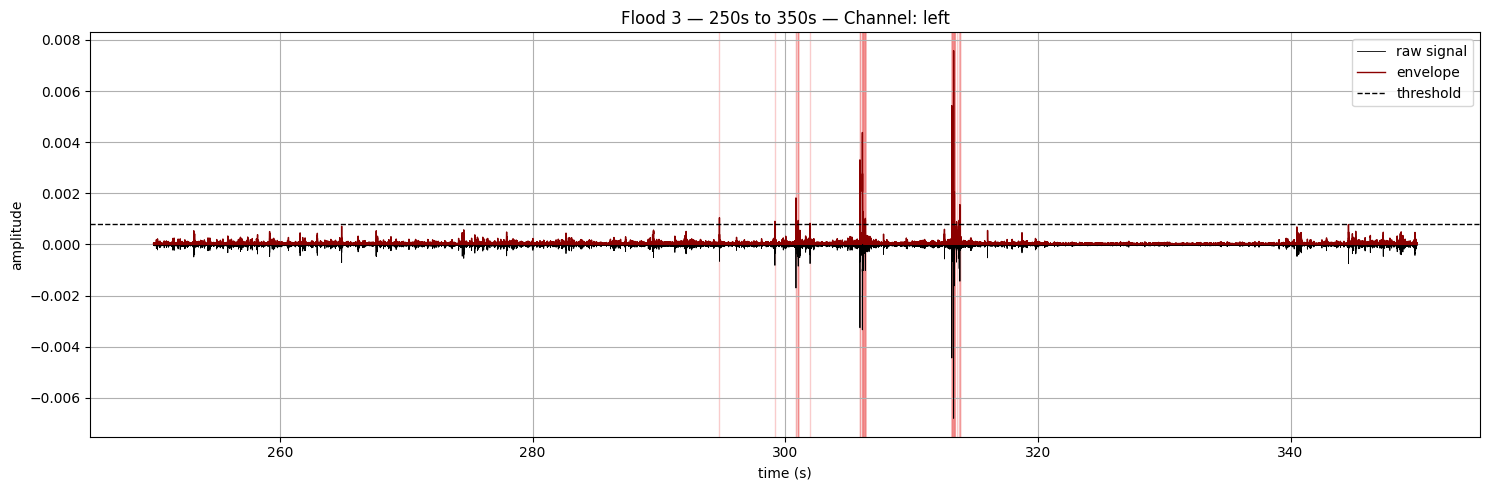

In [47]:
start_time = 250  # in seconds
end_time = 350  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [48]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 2.2390
Max raw signal amplitude in the zoomed-in window: 0.6310


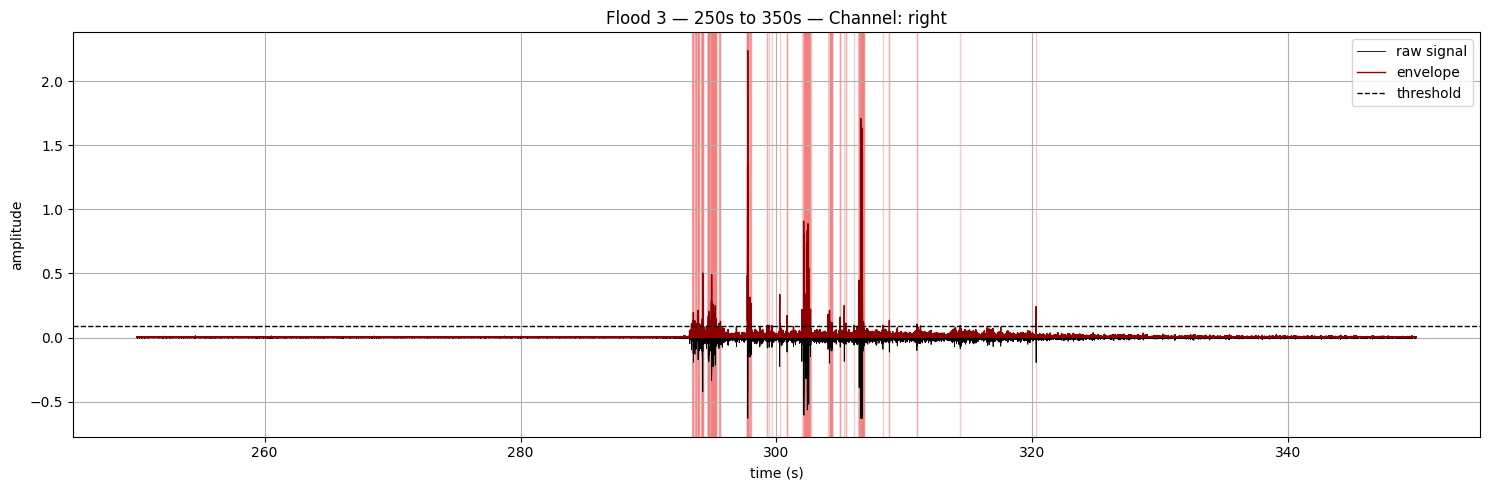

In [49]:
start_time = 250  # in seconds
end_time = 350  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 3 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 4

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3499728829.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


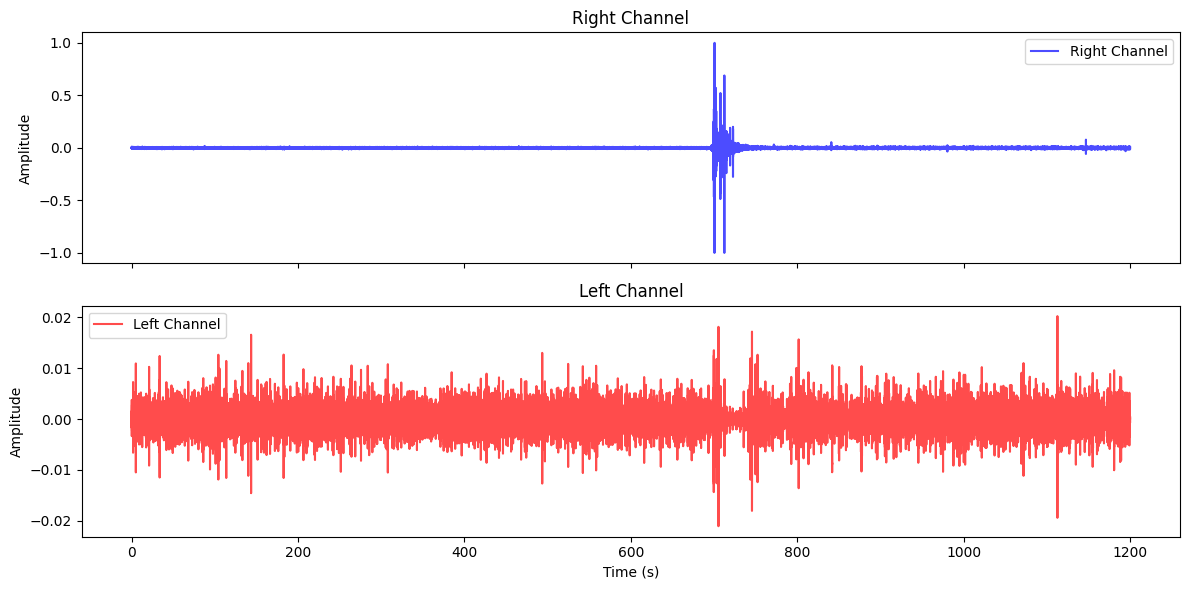

In [62]:
filepath = 'EXP-09-21-23-FLOW4/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe: no impact 
- Still going to try to get a max amplitude

In [63]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\479619074.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.0015
Max raw signal amplitude in the zoomed-in window: 0.0015


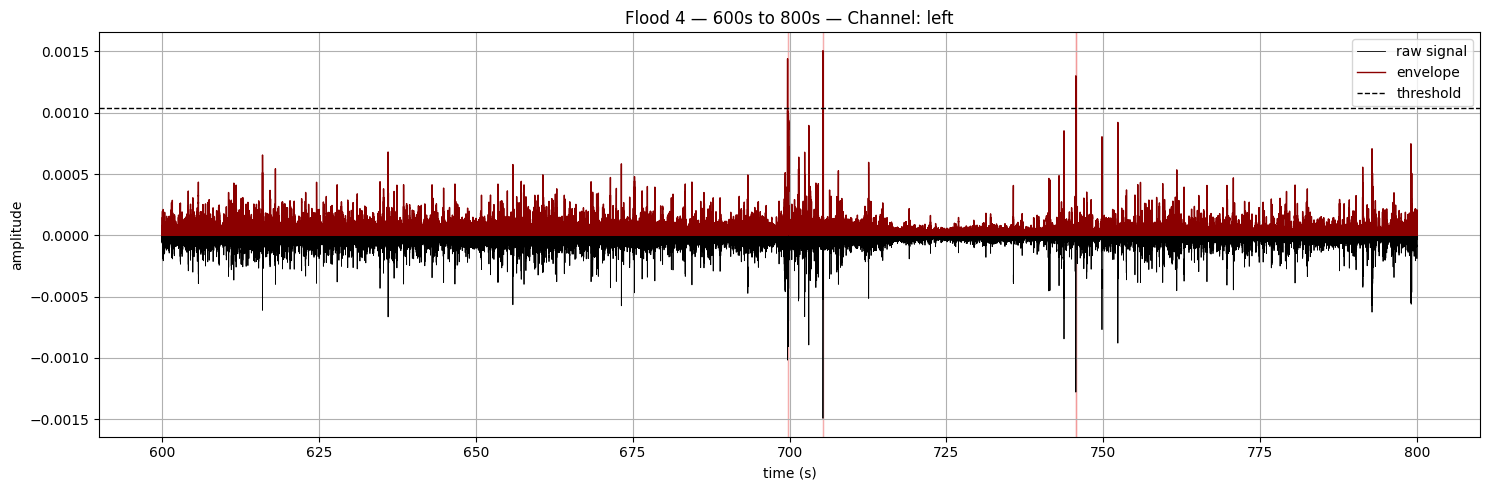

In [64]:
start_time = 600  # in seconds
end_time = 800  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 4 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [51]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 1.9089
Max raw signal amplitude in the zoomed-in window: 0.6310


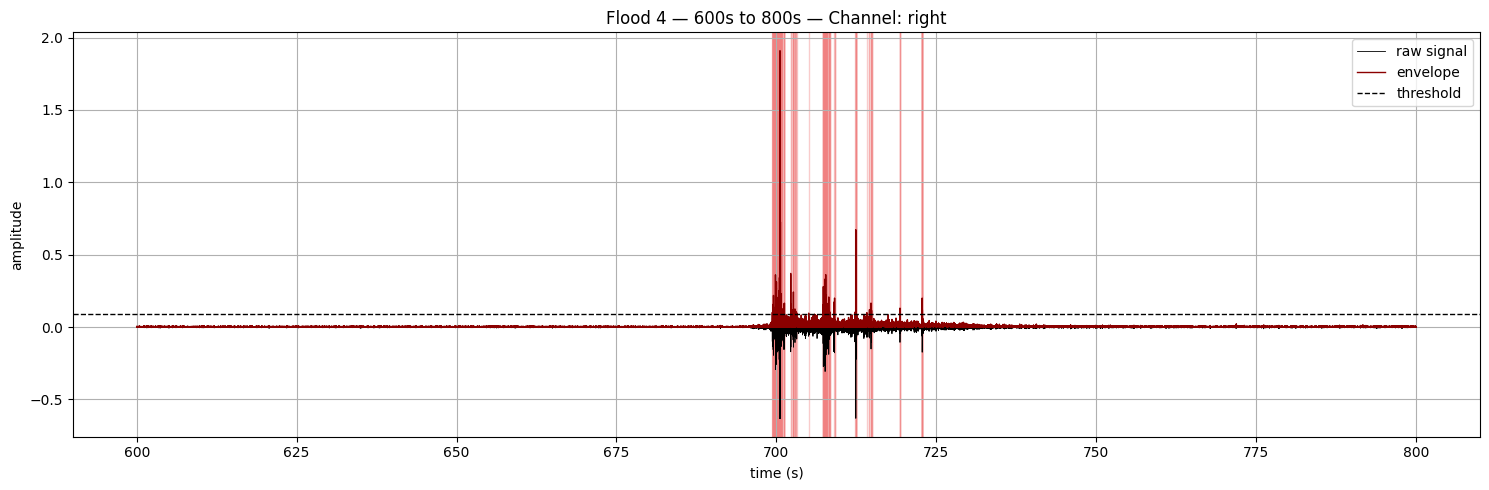

In [53]:
start_time = 600  # in seconds
end_time = 800  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 4 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 5

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3060047001.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


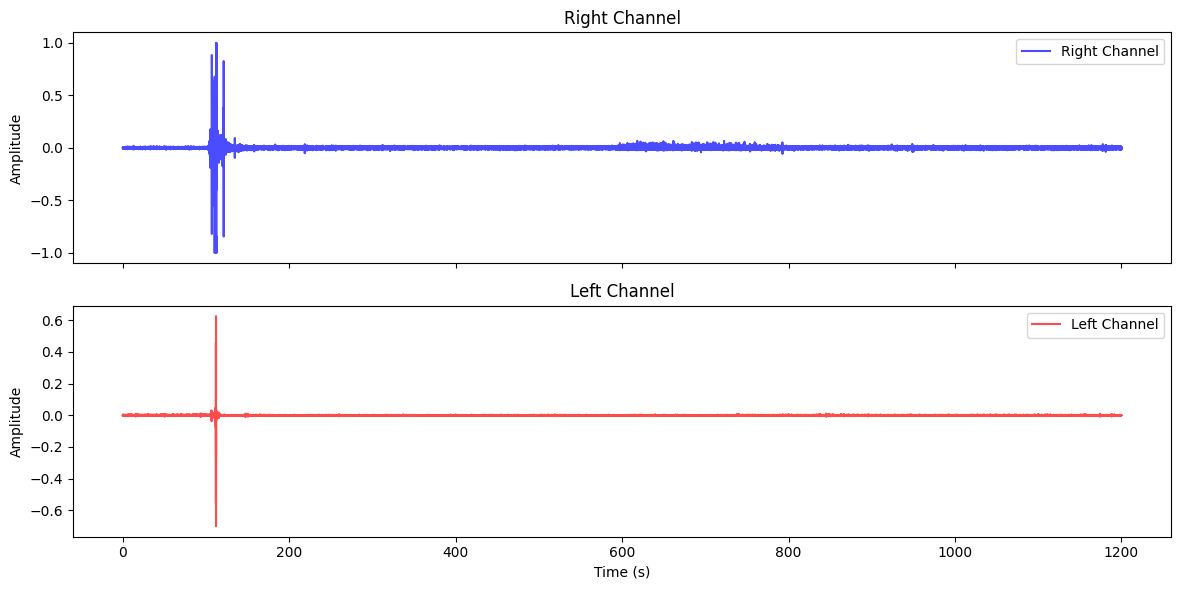

In [54]:
filepath = 'EXP-09-21-23-FLOW5/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [55]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 0.0501
Max raw signal amplitude in the zoomed-in window: 0.0496


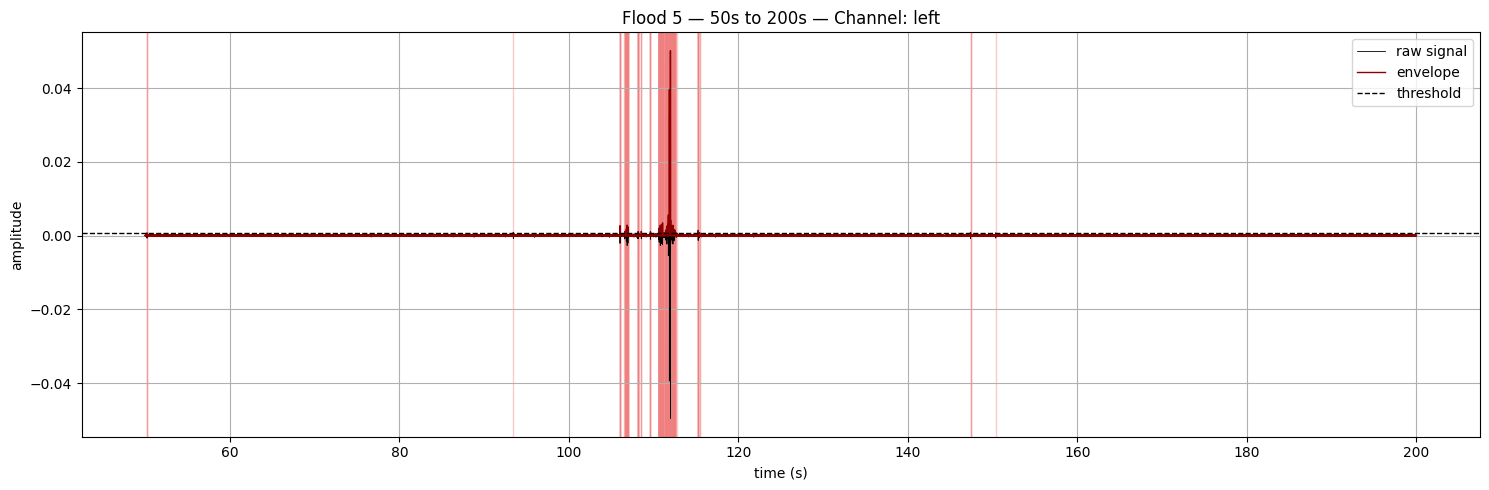

In [56]:
start_time = 50  # in seconds
end_time = 200  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 5 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [57]:
# === USER INPUT ===
left_gain_db = 23   # left channel gain (dB)
right_gain_db = 4 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Max envelope amplitude in the zoomed-in window: 1.5485
Max raw signal amplitude in the zoomed-in window: 0.6310


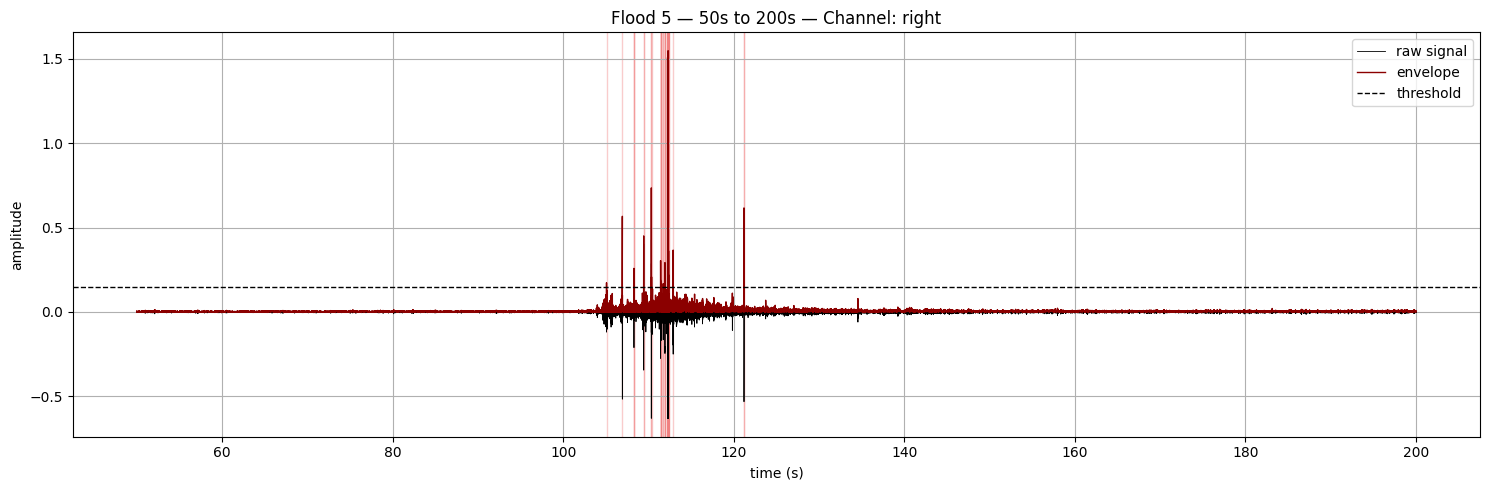

In [58]:
start_time = 50  # in seconds
end_time = 200  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 5 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 6

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\663228995.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


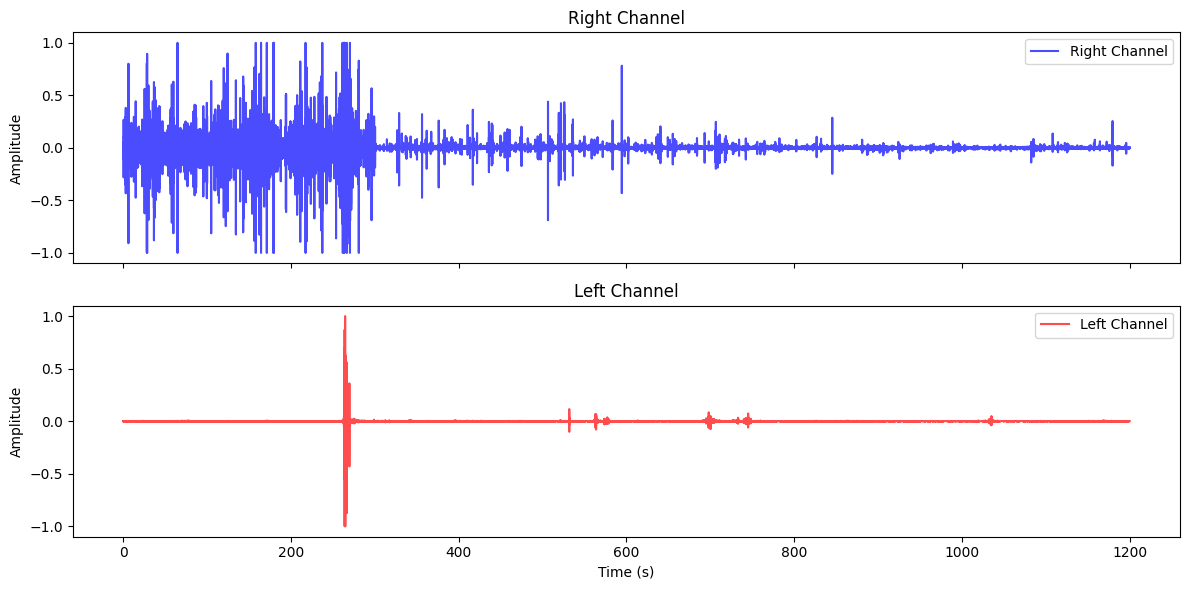

In [68]:
filepath = 'EXP-09-22-23-FLOW6/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [69]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\1113751639.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.0444
Max raw signal amplitude in the zoomed-in window: 0.0316


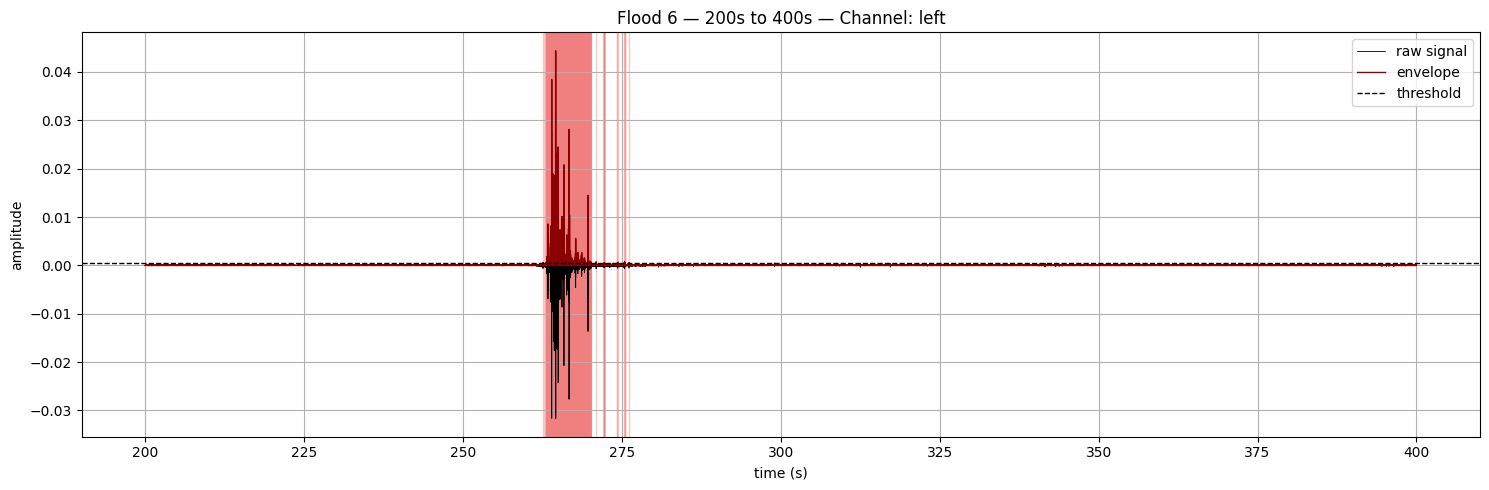

In [70]:
start_time = 200  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 6 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [71]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\1113751639.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 2.4294
Max raw signal amplitude in the zoomed-in window: 0.7943


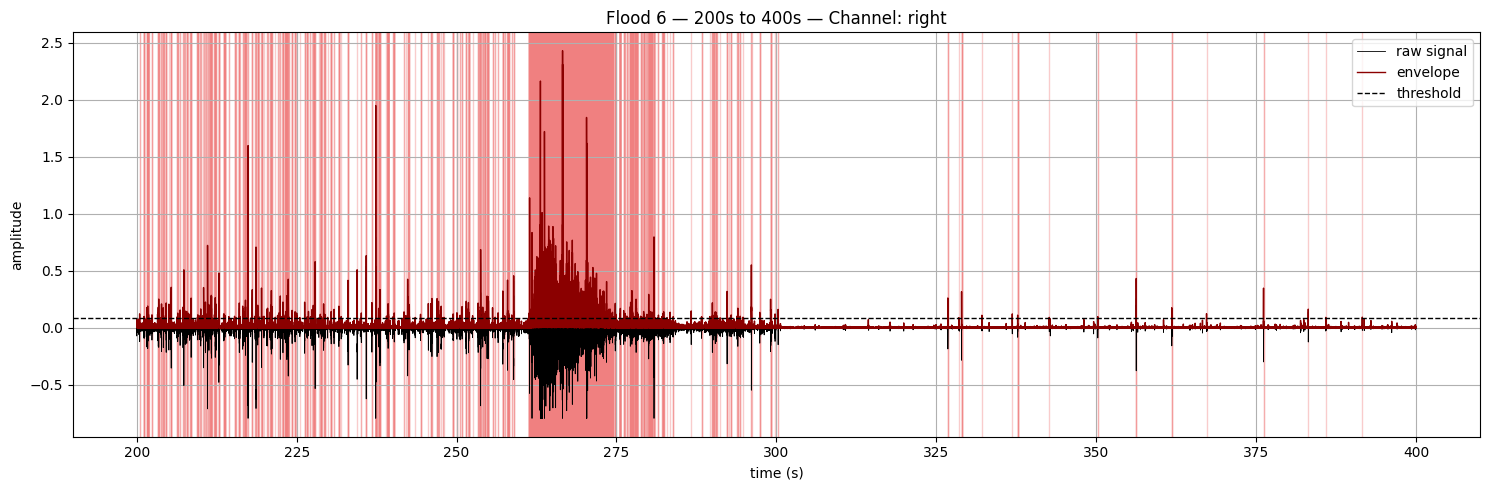

In [ ]:
start_time = 200  # in seconds
end_time = 400  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 6 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 7
These is no recording for this flood :(

### Flood 8

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3764597958.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


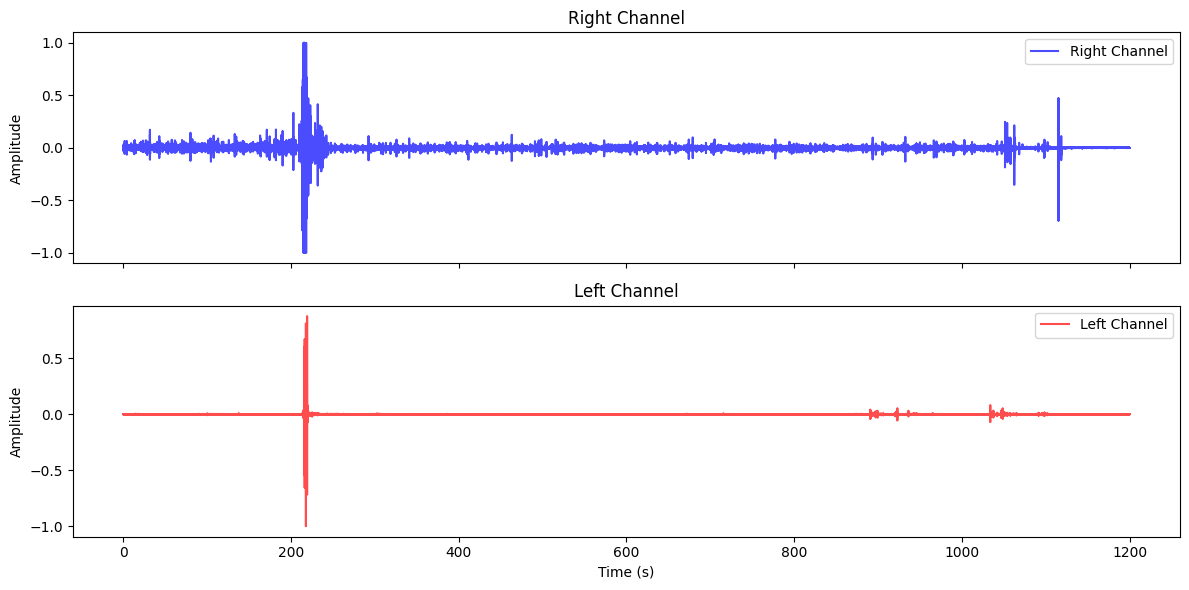

In [73]:
filepath = 'EXP-09-22-23-FLOW8/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [74]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\4124578017.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.0361
Max raw signal amplitude in the zoomed-in window: 0.0316


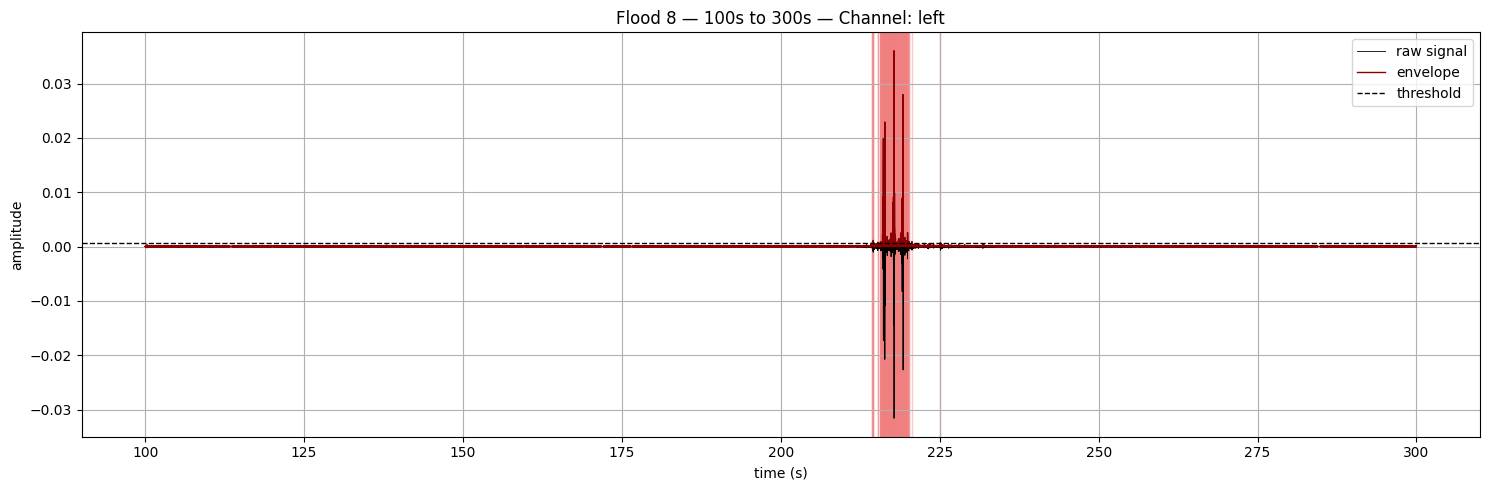

In [76]:
start_time = 100  # in seconds
end_time = 300  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 8 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

mic

In [77]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\4124578017.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 2.1451
Max raw signal amplitude in the zoomed-in window: 0.7943


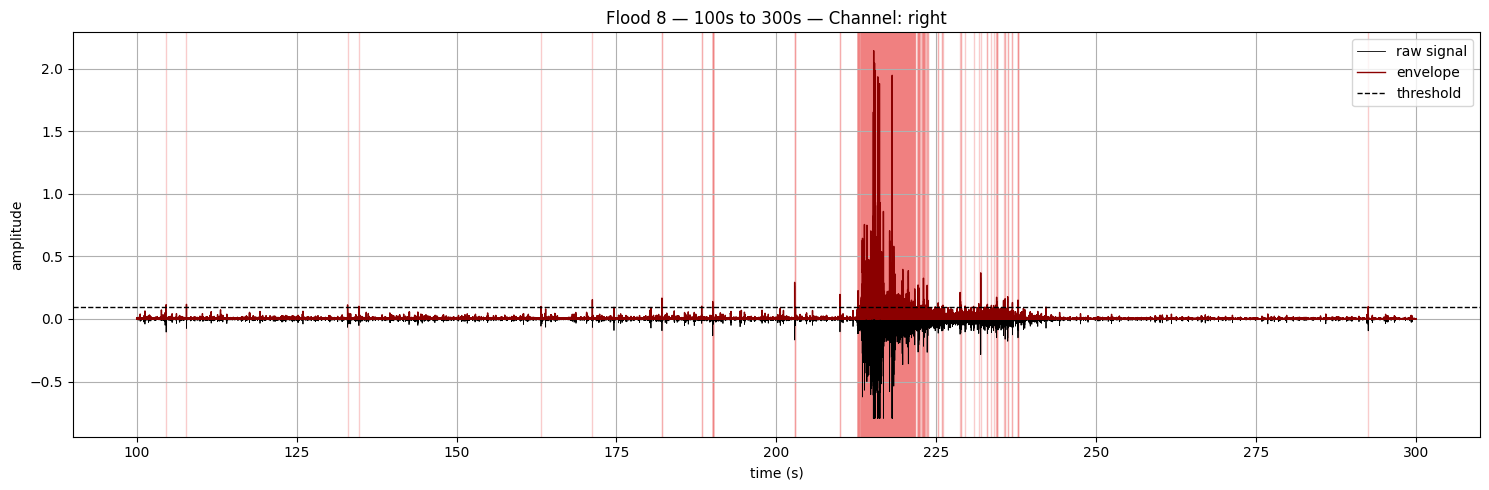

In [78]:
start_time = 100  # in seconds
end_time = 300  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 8 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

### Flood 9

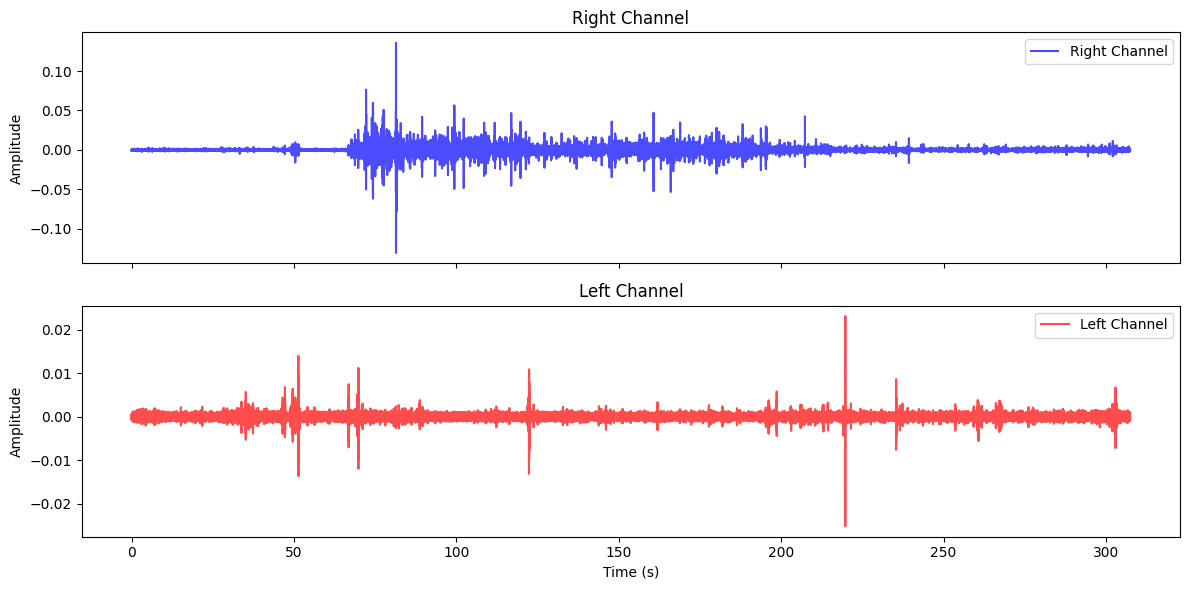

In [80]:
filepath = 'EXP-09-22-23-FLOW9/Nicole_414.wav'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

pipe

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3659753911.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.0008
Max raw signal amplitude in the zoomed-in window: 0.0008


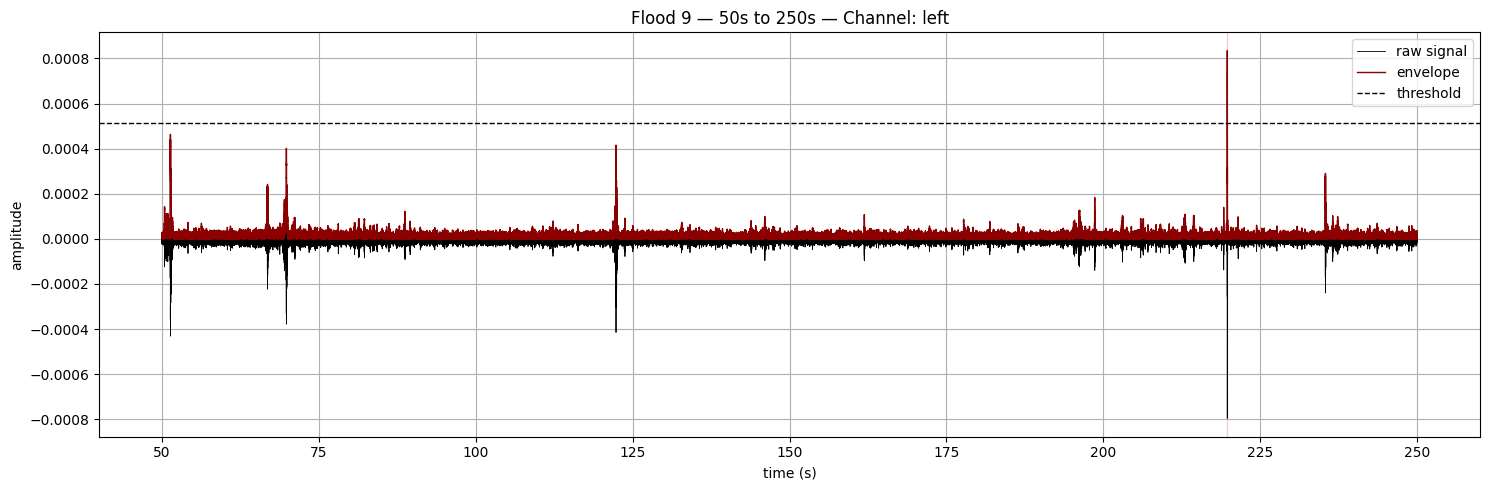

In [83]:
start_time = 50  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 9 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()

microphone

In [84]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "right"  # which one was the impact pipe

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

C:\Users\nicol\AppData\Local\Temp\ipykernel_25492\3659753911.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Max envelope amplitude in the zoomed-in window: 0.1079
Max raw signal amplitude in the zoomed-in window: 0.1078


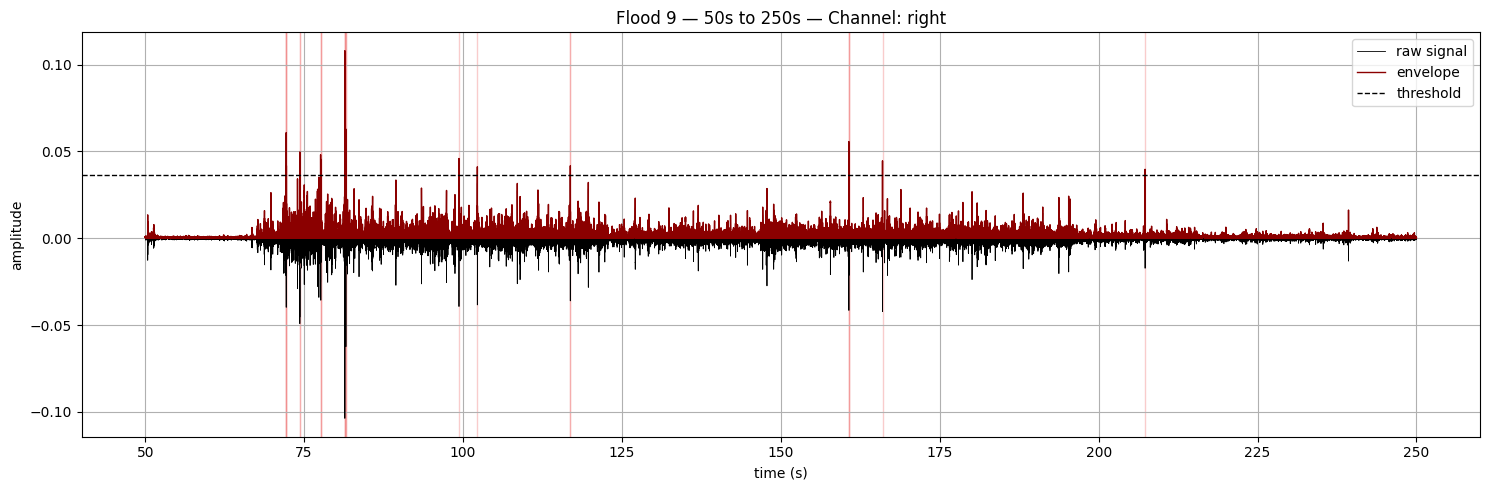

In [85]:
start_time = 50  # in seconds
end_time = 250  # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Flood 9 — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_envelope_zoom = np.max(np.abs(envelope_zoom))
print(f"Max envelope amplitude in the zoomed-in window: {max_envelope_zoom:.4f}")
max_signal_zoom = np.max(np.abs(y_zoom))
print(f"Max raw signal amplitude in the zoomed-in window: {max_signal_zoom:.4f}")

plt.show()